## Automatic Differentiation

In [7]:
"""
This script prepares your Python environment by loading essential tools for handling environment variables, 
interacting with a Neo4j graph database, and utilizing a bespoke graph module, which could be sourced 
from either a local graph class or optionally from the trengx package.

import os: 
This line imports the built-in Python module os, which provides a portable way of using 
operating system dependent functionality, like reading or writing to the environment.

from dotenv import load_dotenv: 
This line imports the load_dotenv function from the dotenv module. 
This function reads a file (by default, a file named .env in the same directory as the script) and 
loads its contents as environment variables.

from neo4j import GraphDatabase as graphdb: 
This line imports the GraphDatabase class from the neo4j module, and renames it to graphdb 
in your script for convenience. This class is used to interact with a Neo4j graph database.

import sys and sys.path.append('../trengx'): 
These lines modify the system path that Python uses to look for modules. The sys module provides access 
to some variables used or maintained by the Python interpreter. In this case, it's used to add 
the parent directory's trengx subdirectory to the list of directories that Python will search when you import a module.

import graph: This line imports the graph module, which is expected to be found in the trengx directory 
that was just added to the system path. This module likely contains the Graph class that you use in your script. 
The specific functionality of this module depends on its implementation, but based on context, 
it likely provides tools for creating and manipulating a computational graph.
"""

# %pip install trengx
# from trengx import graph

import os
import sys
sys.path.append('../trengx')
import graph

In [8]:
# Retrieve secrets (confidential credentials) from environment variables stored in .env file
uri = os.getenv('NEO4J_URI') # Get the value of the uri variable
user = os.getenv('NEO4J_USER') # Get the value of the user variable
password= os.getenv('NEO4J_PASSWORD')  # Get the value of the password variable

# Create a Graph class instance using Graph class in neo4j_graph.py (module)
g = graph.Graph(uri, user, password)

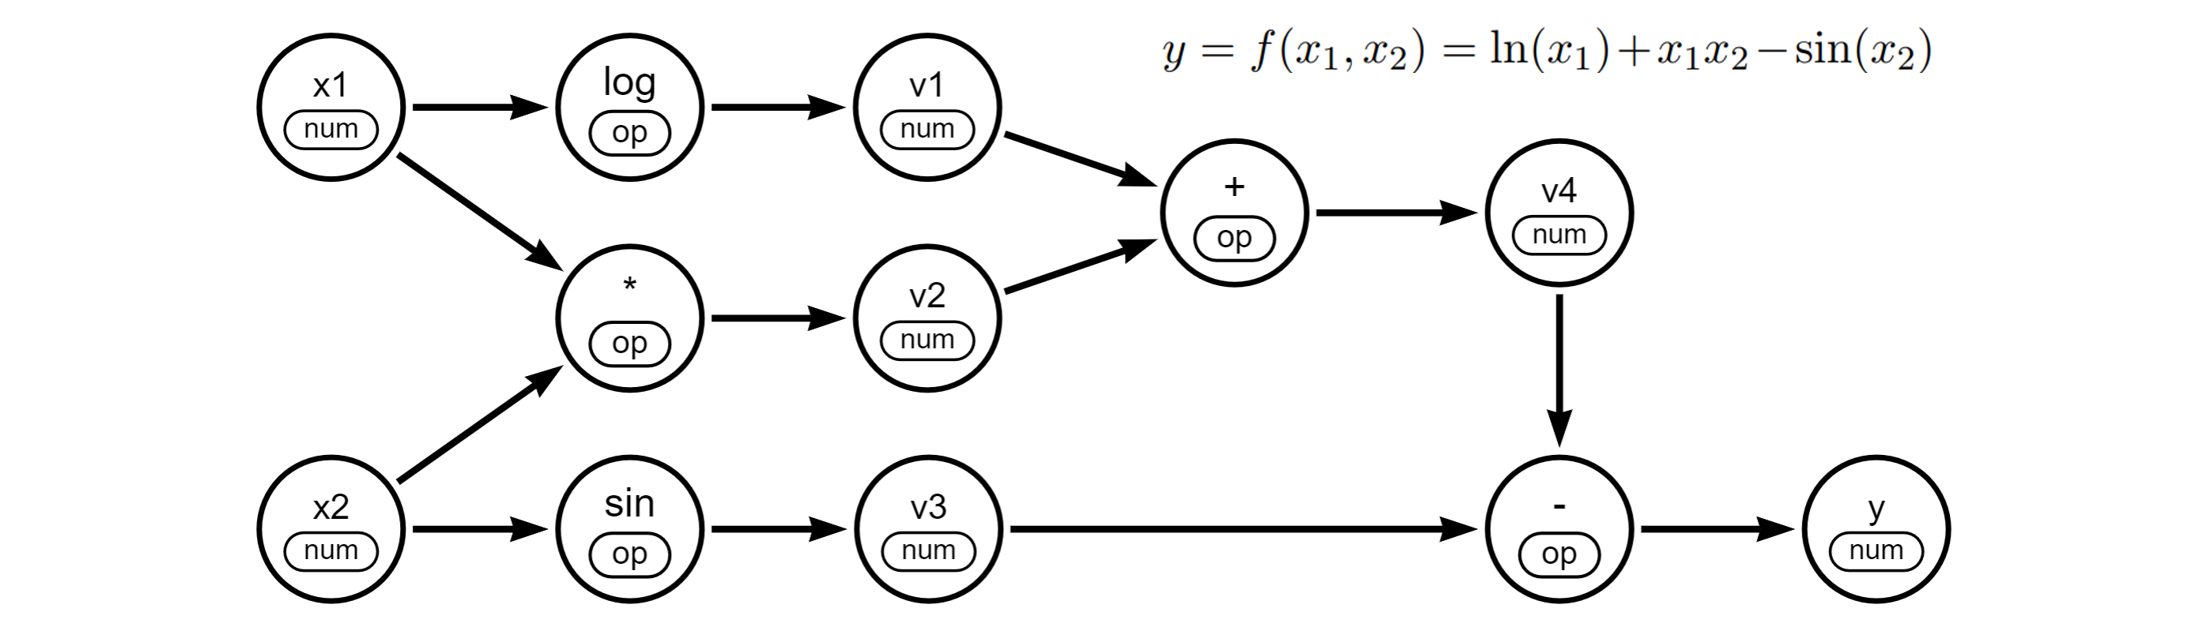

In [9]:
g.delete_all()

x1 = g.add_node('num', {'name': 'x1', 'value': 2}) 
x2 = g.add_node('num', {'name': 'x2', 'value': 5}) 

log = g.add_node('op', {'name': 'log'})  
g.add_edge('num2op', x1['id'], log['id'])  

sin = g.add_node('op', {'name': 'sin'})  
g.add_edge('num2op', x2['id'], sin['id'])  

mul = g.add_node('op', {'name': '*'})  
g.add_edge('num2op', x1['id'], mul['id'])  
g.add_edge('num2op', x2['id'], mul['id'])  

v1 = g.add_node('num', {'name': 'v1', 'value': 0}) 
g.add_edge('op2num', log['id'], v1['id'])

v3 = g.add_node('num', {'name': 'v3', 'value': 0}) 
g.add_edge('op2num', sin['id'], v3['id'])

v2 = g.add_node('num', {'name': 'v2', 'value': 0}) 
g.add_edge('op2num', mul['id'], v2['id'])

add = g.add_node('op', {'name': '+'})
g.add_edge('num2op', v1['id'], add['id'])
g.add_edge('num2op', v2['id'], add['id'])

v4 = g.add_node('num', {'name': 'v4', 'value': 0}) 
g.add_edge('op2num', add['id'], v4['id'])

sub = g.add_node('op', {'name': '-'}) 
g.add_edge('num2op', v4['id'], sub['id'], {'reverse': False})  
g.add_edge('num2op', v3['id'], sub['id'], {'reverse': True})  

y = g.add_node('num', {'name': 'y', 'value': 0}) 
g.add_edge('op2num', sub['id'], y['id'])





{'id': 'b197dffe-98a1-4703-a0cc-8705cbbf3a0e',
 'label': 'op2num',
 'out_id': 'ee2854dc-a923-4514-ac7c-55667235b85b',
 'in_id': '4bfce67a-175d-4cb0-9cd9-0d6937742fbc',
 'properties': {}}

In [10]:
# Forward Propagation

g.set_node_value(x1['id'], 2)
g.set_node_value(x2['id'], 5)

print (g.get_node_value(v1['id']))
print (g.get_node_value(v2['id']))
print (g.get_node_value(v3['id']))
print (g.get_node_value(v4['id']))
print (g.get_node_value(y['id']))

0.6931471805599453
10
-0.9589242746631385
10.693147180559945
11.652071455223084
